## Problem 1: RAG Agent

In [9]:
# Importing Necessary Libraries
import os
import requests
import zipfile
import sqlite3
import operator
import pandas as pd

from typing import TypedDict, Annotated, List
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings

from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage
from langchain_ollama.chat_models import ChatOllama
from langchain_core.tools import tool
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode

Defining Necessary variables and links

In [2]:
# --- Configuration ---
DATA_DIR = "Data"
DATA_FILE = os.path.join(DATA_DIR, "HR_Policy.txt")
VECTORSTORE_DIR = "hr_policy_vectorstore"
EMBEDDING_MODEL = "all-MiniLM-L6-v2"
CHUNK_SIZE = 1000
CHUNK_OVERLAP = 150

In [3]:
DATA_FILE

'Data/HR_Policy.txt'

In [4]:
def load_and_chunk_documents():
    """
    Loads the HR policy data from the TXT file and splits it into smaller chunks.
    """
    print("\n--- Step 1: Loading and Chunking Documents ---")
    # UPDATED: Check for the .txt file.
    if not os.path.exists(DATA_FILE):
        print(f"Error: {DATA_FILE} not found. Please ensure the dataset is downloaded.")
        return None

    # UPDATED: Read the entire content of the text file instead of using pandas.
    with open(DATA_FILE, 'r', encoding='utf-8') as f:
        full_text = f.read()
    
    # The text splitter works on a list of documents. We treat the whole file as one document.
    documents = [full_text]
    
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=CHUNK_SIZE,
        chunk_overlap=CHUNK_OVERLAP
    )
    
    chunks = text_splitter.create_documents(documents)
    print(f"Created {len(chunks)} document chunks from the text file.")
    return chunks

In [5]:
def create_and_store_embeddings(chunks):
    """
    Creates embeddings for the document chunks and stores them in a Chroma vector store.
    """
    print("\n--- Step 2: Creating and Storing Embeddings ---")
    if not chunks:
        print("No chunks to process. Aborting.")
        return

    # Initialize the embedding model from HuggingFace
    print(f"Loading embedding model: '{EMBEDDING_MODEL}'...")
    embeddings = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL)

    # Create the Chroma vector store
    # This will process all chunks and store their vector representations.
    # It will be persisted to disk in the VECTORSTORE_DIR.
    print(f"Creating vector store in '{VECTORSTORE_DIR}'...")
    Chroma.from_documents(
        chunks,
        embeddings,
        persist_directory=VECTORSTORE_DIR
    )
    print("Vector store created and persisted successfully.")


In [6]:
# Manually download the dataset first as per the instructions in the function.
doc_chunks = load_and_chunk_documents()
if doc_chunks:
    create_and_store_embeddings(doc_chunks)
print("\n--- Data Ingestion Complete ---")
print(f"Your vector store is ready in the '{VECTORSTORE_DIR}' directory.")


--- Step 1: Loading and Chunking Documents ---
Created 25 document chunks from the text file.

--- Step 2: Creating and Storing Embeddings ---
Loading embedding model: 'all-MiniLM-L6-v2'...


/tmp/ipykernel_29053/200756242.py:12: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL)
/home/sushobhon/agentic-ai-workshop/agent_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Creating vector store in 'hr_policy_vectorstore'...
Vector store created and persisted successfully.

--- Data Ingestion Complete ---
Your vector store is ready in the 'hr_policy_vectorstore' directory.


In [ ]:
# --- Configuration ---
VECTORSTORE_DIR = "hr_policy_vectorstore"
EMBEDDING_MODEL = "all-MiniLM-L6-v2"
OLLAMA_MODEL = "mistral:latest" # Make sure this model is pulled in Ollama

In [11]:
# --- 1. RAG Tool Definition ---
# Initialize embeddings and vector store once to be used by the tool
print("Loading embeddings and vector store for RAG tool...")
embeddings = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL)
vectorstore = Chroma(persist_directory=VECTORSTORE_DIR, embedding_function=embeddings)
retriever = vectorstore.as_retriever(search_kwargs={"k": 3}) # Retrieve top 3 results

Loading embeddings and vector store for RAG tool...


/tmp/ipykernel_29053/1493662442.py:5: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(persist_directory=VECTORSTORE_DIR, embedding_function=embeddings)


In [12]:
# Defining retrive data function
@tool
def retrieve_hr_policy_info(query: str) -> str:
    """
    Searches the HR policy vector database to find relevant information
    for a given user query. Use this to answer questions about HR policies,
    such as leave, benefits, code of conduct, etc.
    """
    print(f"--- Executing RAG Tool for query: '{query}' ---")
    results = retriever.invoke(query)
    
    if not results:
        return "No relevant information found in the HR policy documents."
        
    # Format the results into a single string to be passed to the LLM
    context = "\n\n---\n\n".join([doc.page_content for doc in results])
    print("--- RAG Tool Finished ---")
    return f"Retrieved context: \n{context}"


In [13]:
# --- 2. Agent State and Graph Definition ---

class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]

In [16]:
# --- 3. Graph Nodes and Conditional Logic ---

def should_continue(state: AgentState) -> str:
    """
    Decides the next step. If the LLM made a tool call, route to the 'tools' node.
    Otherwise, end the process.
    """
    last_message = state['messages'][-1]
    if last_message.tool_calls:
        return "tools"
    return END

def call_model(state: AgentState):
    """
    Calls the Ollama LLM. It will either respond directly or decide to use a tool.
    """
    messages = state['messages']
    # The final response generation should not use the tool-calling model
    # to avoid loops. We'll decide which model to use based on the flow.
    # If the last message was a tool result, we use the base model to synthesize an answer.
    if isinstance(messages[-1], ToolMessage):
        print("--- Synthesizing final answer from tool output ---")
        response = model.invoke(messages)
    else:
        # This is the first call, where the model can decide to use a tool.
        print("--- Agent is deciding next step (respond or use tool) ---")
        response = model_with_tools.invoke(messages)
        
    return {"messages": [response]}



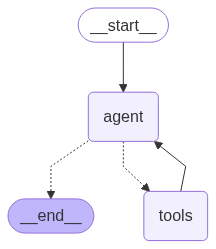

In [26]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [27]:
print("--- HR Policy RAG Agent Initializing ---")
    
# Check if the vector store exists
if not os.path.exists(VECTORSTORE_DIR):
    print(f"Error: Vector store not found at '{VECTORSTORE_DIR}'")
    print("Please run the 'rag_data_ingestion.py' script first to create it.")
    exit()

# Define the tool(s) for the agent
tools = [retrieve_hr_policy_info]

# Initialize the Ollama model
model = ChatOllama(model=OLLAMA_MODEL)

# Bind the tool to the model
model_with_tools = model.bind_tools(tools)

# Define the LangGraph workflow
workflow = StateGraph(AgentState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", ToolNode(tools))

workflow.set_entry_point("agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "tools": "tools",
        END: END
    }
)
workflow.add_edge("tools", "agent")

# Compile the graph
app = workflow.compile()


--- HR Policy RAG Agent Initializing ---


In [29]:
print("\n--- Starting HR Policy Assistant ---")
print("Type 'exit' to end the conversation.")

while True:
    user_input = input("\nYour question: ")
    if user_input.lower() == 'exit':
        break
    
    inputs = {"messages": [HumanMessage(content=user_input)]}
    
    # Stream the intermediate steps to see the agent's reasoning
    for output in app.stream(inputs):
        for key, value in output.items():
            print(f"\nOutput from node '{key}':")
            print("---")
            # Print the message content for clarity
            if 'messages' in value:
                for msg in value['messages']:
                    if hasattr(msg, "tool_calls") and msg.tool_calls:
                        print(f"Tool Call: {msg.tool_calls}")
            else:
                print(value)
        print("\n")
    
    # The final answer is the last message from the 'agent' node
    final_response = app.invoke(inputs)
    print("---")
    print("Final Answer:", final_response['messages'][-1].content)
    print("---")


--- Starting HR Policy Assistant ---
Type 'exit' to end the conversation.
--- Agent is deciding next step (respond or use tool) ---

Output from node 'agent':
---


--- Agent is deciding next step (respond or use tool) ---
---
Final Answer:  Your previous question was: "What is the HR policy function?" This function retrieves relevant information about HR policies, such as leave, benefits, code of conduct, etc., from a database. It takes a user query as input and returns the most relevant policy information.
---
